In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
rows = train.shape[0]
columns = train.shape[1]
print(f"The train dataset contains {rows} rows and {columns} columns")

The train dataset contains 595212 rows and 59 columns


# data quality check
### 1. Null or missing values check

In [5]:
train.isnull().any().any()

False

In [6]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

<AxesSubplot:>

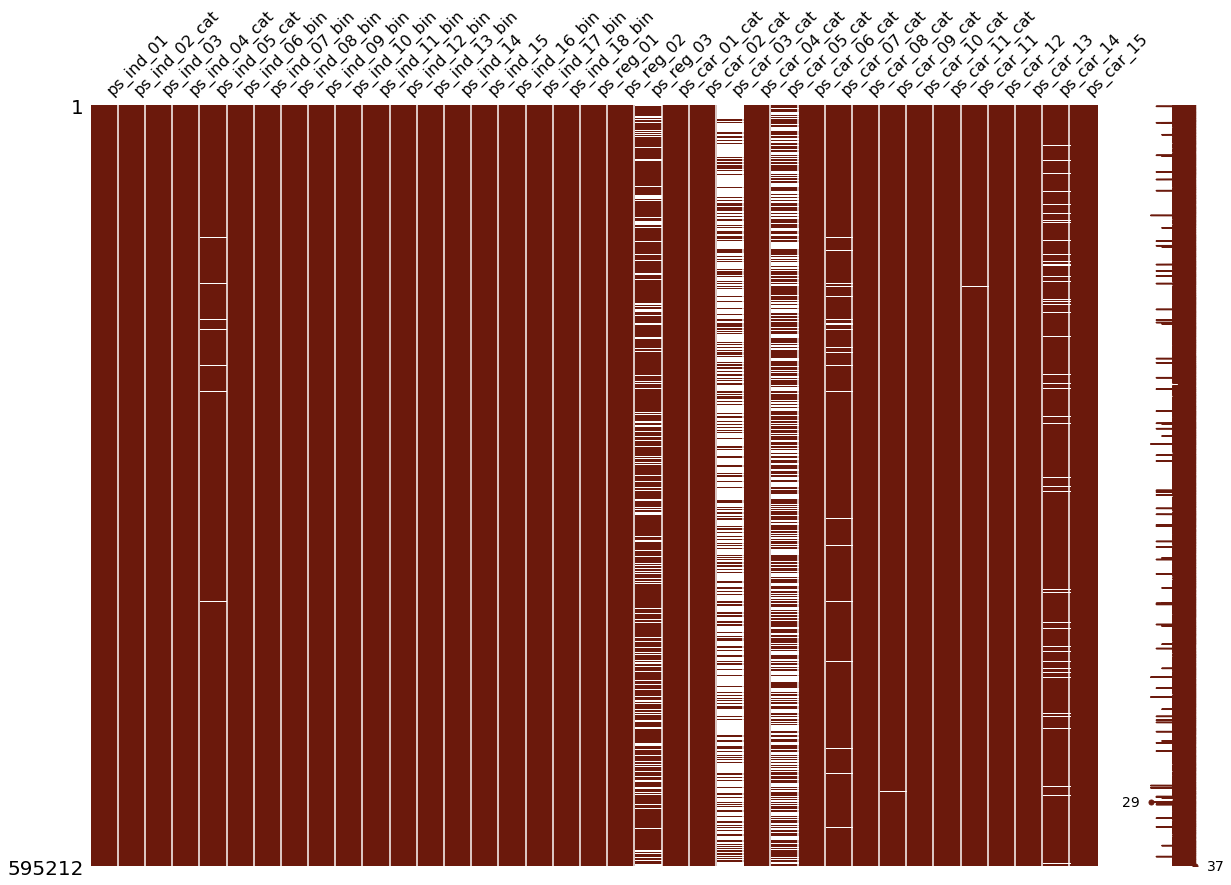

In [13]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

### 2. Target variable inspection

In [14]:
data = [go.Bar(x = train['target'].value_counts().index.values,
               y = train['target'].value_counts().values,
               text = 'Distribution of target variable')]

layout = go.Layout(title = 'Target variable distribution')
fig = go.Figure(data = data, layout = layout)

py.iplot(fig, filename = 'basic-bar')

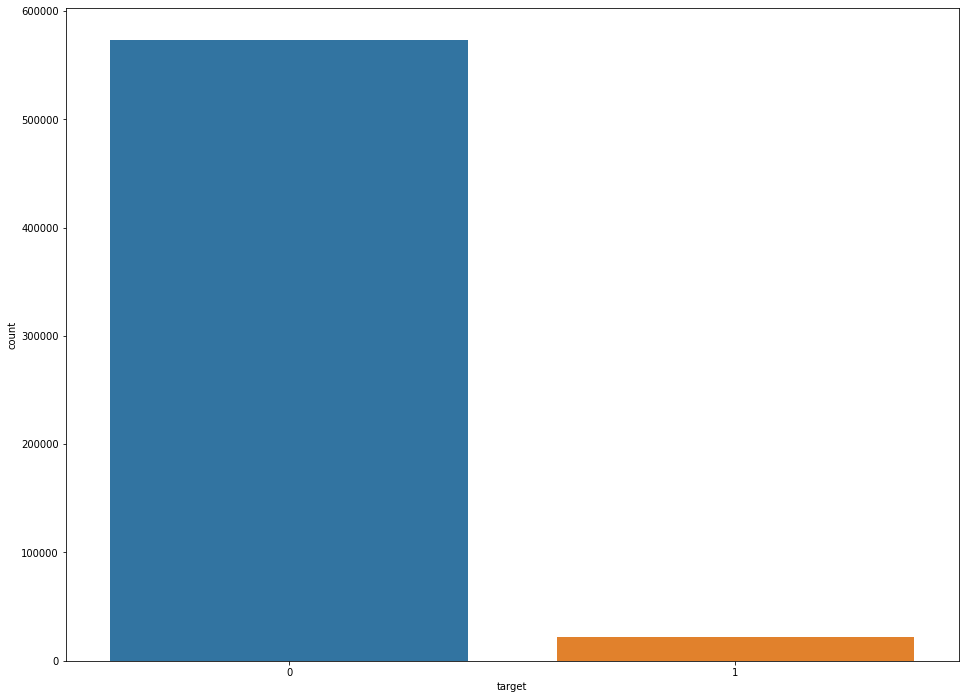

In [23]:
plt.figure(figsize = (16, 12))
sns.countplot('target', data = train)
plt.show()

### 3. Datatype check

In [17]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [19]:
train_float = train.select_dtypes(include = ['float64'])
train_int = train.select_dtypes(include = ['int64'])

### 4. Correlation plots

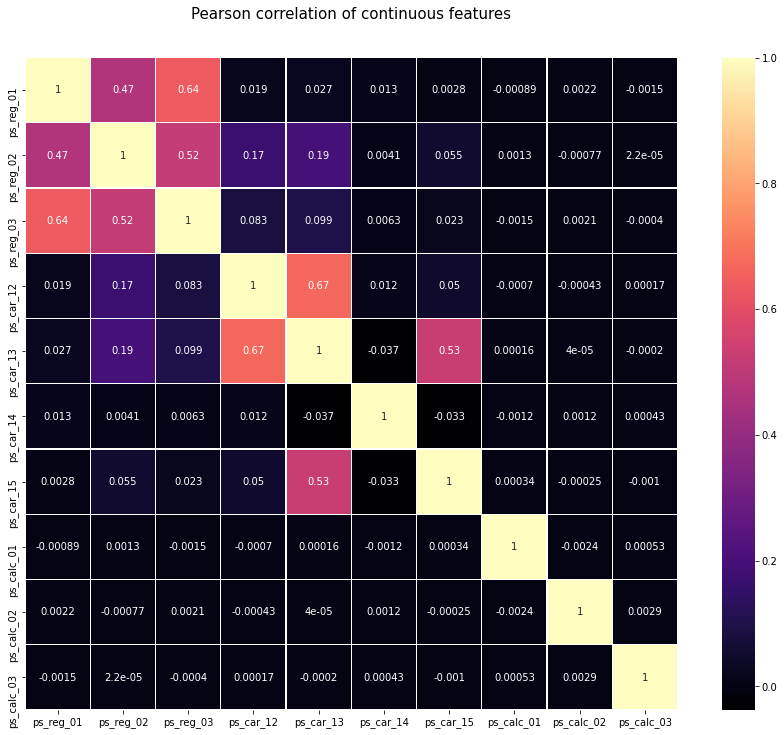

In [27]:
# float
colormap = plt.cm.magma
plt.figure(figsize = (16, 12))
plt.title('Pearson correlation of continuous features', y = 1.05, size = 15)
sns.heatmap(train_float.corr(), linewidths = 0.1, vmax = 1.0, square = True,
           cmap = colormap, annot = True, linecolor = 'white')
plt.show()

In [36]:
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

### Mutual information plots
- For classification problems

In [38]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors = 3, random_state = 17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary features inspection

In [43]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col] == 0).sum())
    one_list.append((train[col] == 1).sum())

trace1 = go.Bar(x = bin_col, y = zero_list, name = 'Zero count')
trace2 = go.Bar(x = bin_col, y = one_list, name = 'One count')

data = [trace1, trace2]
layout = go.Layout(barmode = 'stack', title = 'Count of 1 and 0 in binary variables')

fig = go.Figure(data= data, layout = layout)
py.iplot(fig, filename = 'stacked-bar')

# Categorical and Ordinal feature inspection
### Feature importance via Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 150, max_depth = 8, min_samples_leaf = 4,
                             max_features = 0.2, n_jobs = -1, random_state = 0)
rf.fit(train.drop(['id', 'target'], axis = 1), train.target)
features = train.drop(['id', 'target'], axis = 1).columns.values
print("----done----")

----done----


In [45]:
trace = go.Scatter(y = rf.feature_importances_,
                   x = features,
                   mode = 'markers',
                   marker = dict(sizemode = 'diameter',
                                 sizeref = 1,
                                 size = 13,
                                 color = rf.feature_importances_,
                                 colorscale = 'Portland',
                                 showscale = True),
                  text = features)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [47]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### decision tree visualization

In [50]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

FileNotFoundError: [Errno 2] No such file or directory: 'dot'

### freature importance via <u>Gradient Boosting model</u>

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [52]:
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [53]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')